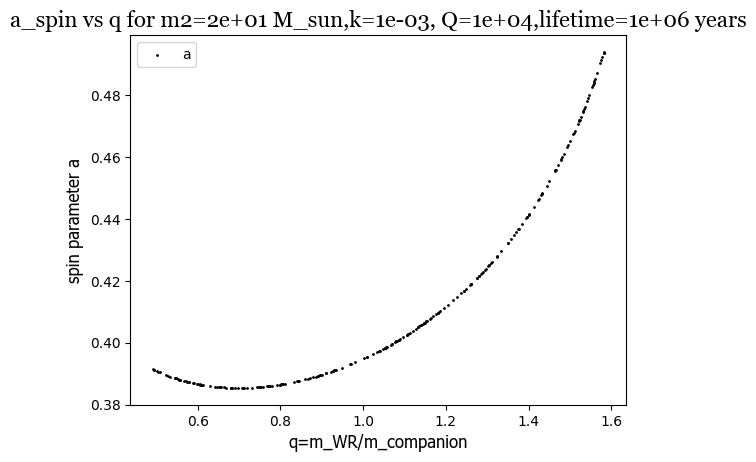

C:\Users\Hitomi\AppData\Local\Temp\ipykernel_12424\529566750.py:66: RuntimeWarning: invalid value encountered in scalar power
  return K1*(f**(13/3))*(f/2-Omega)


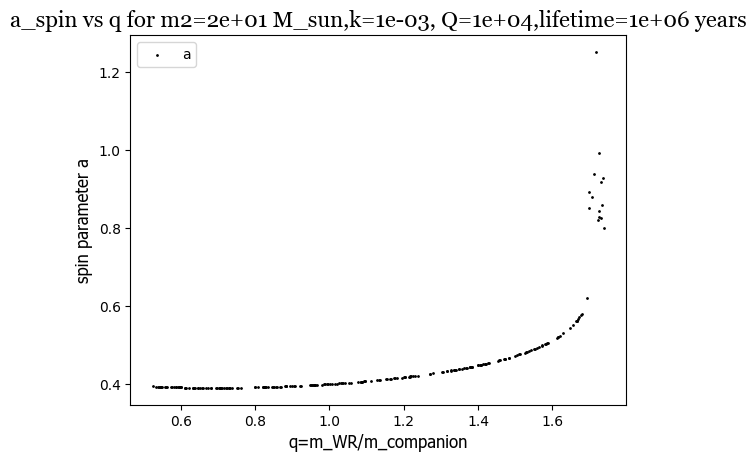

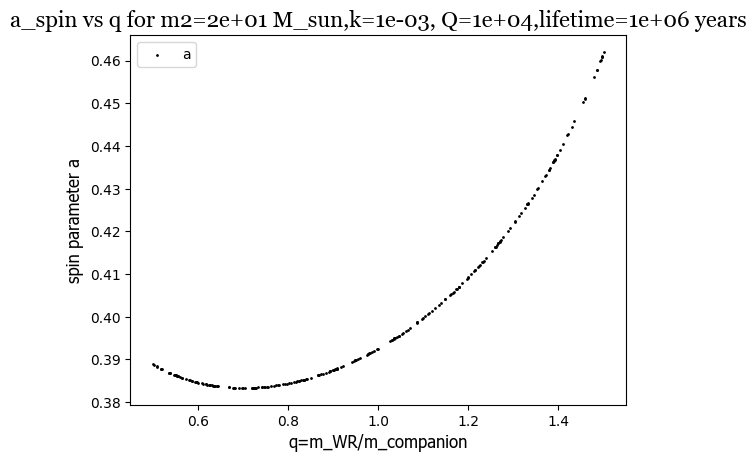

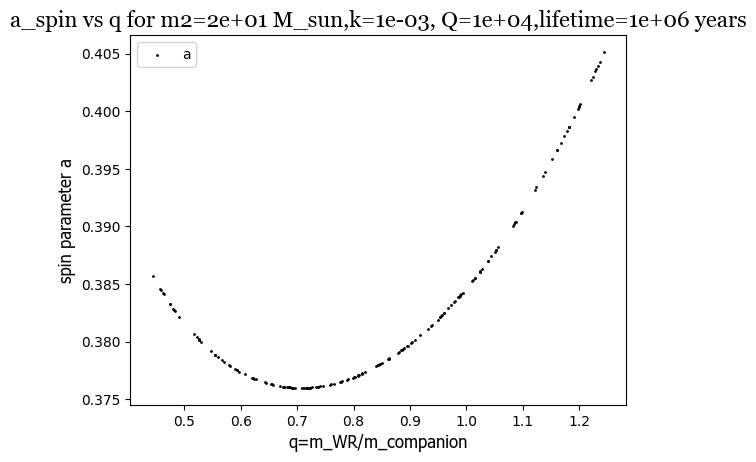

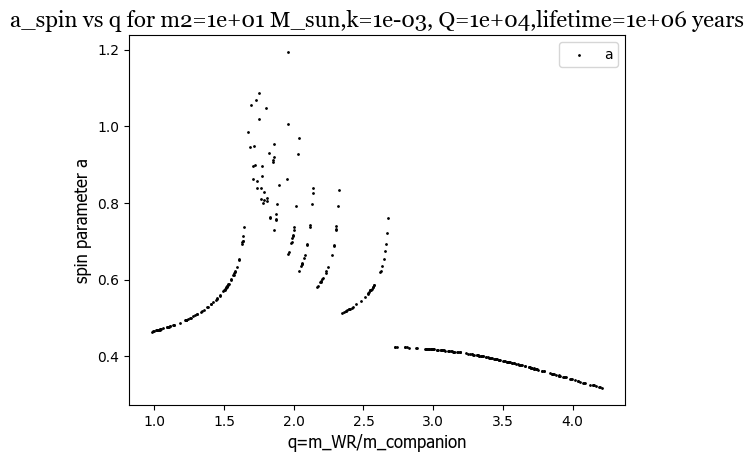

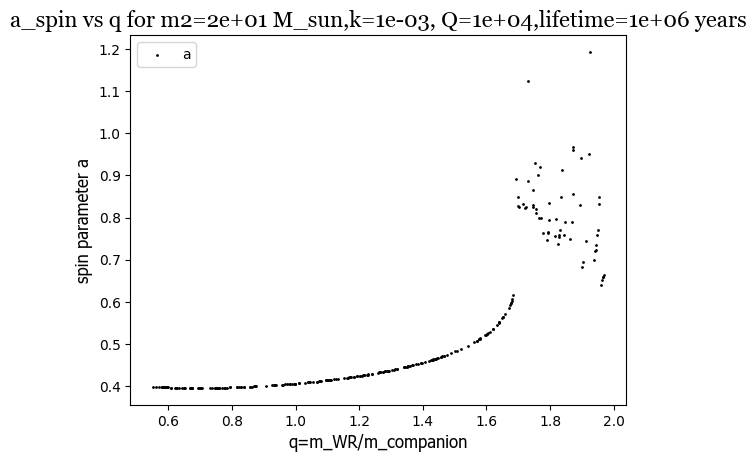

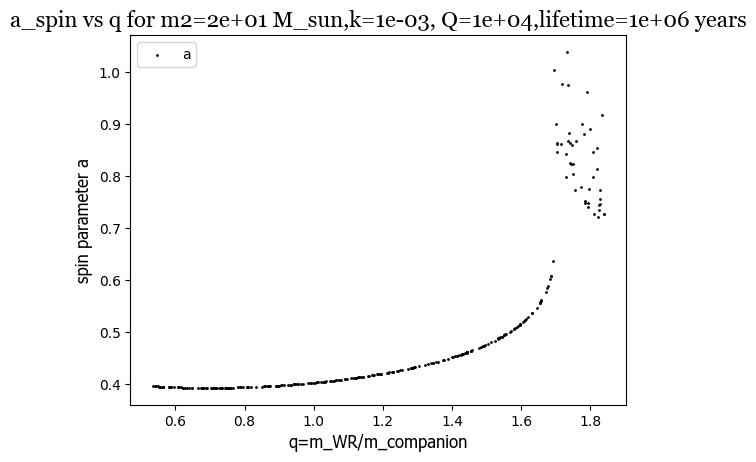

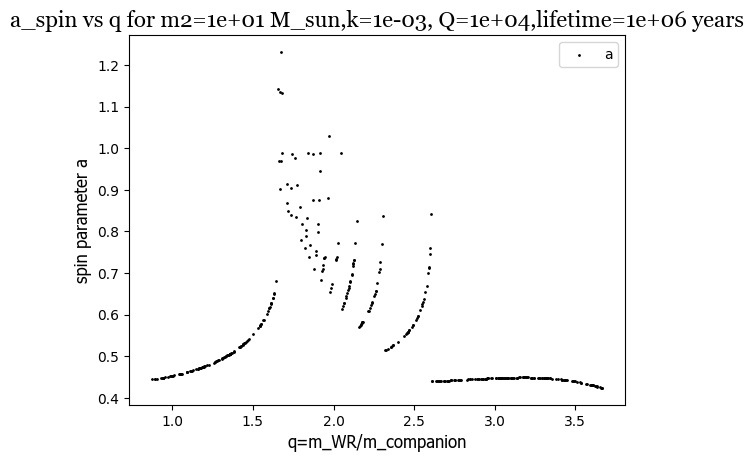

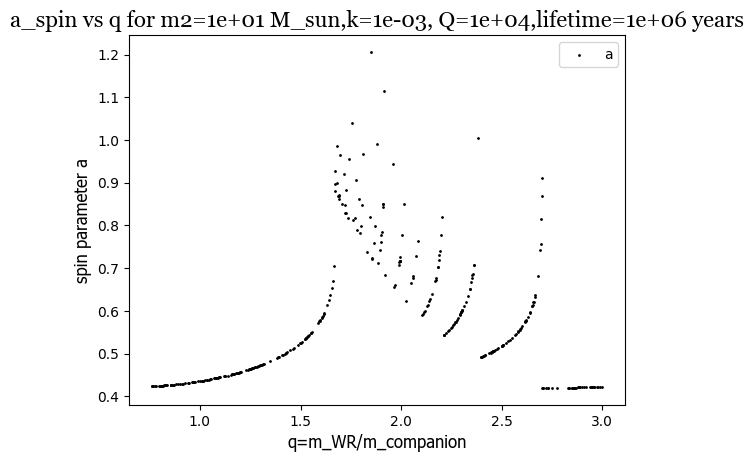

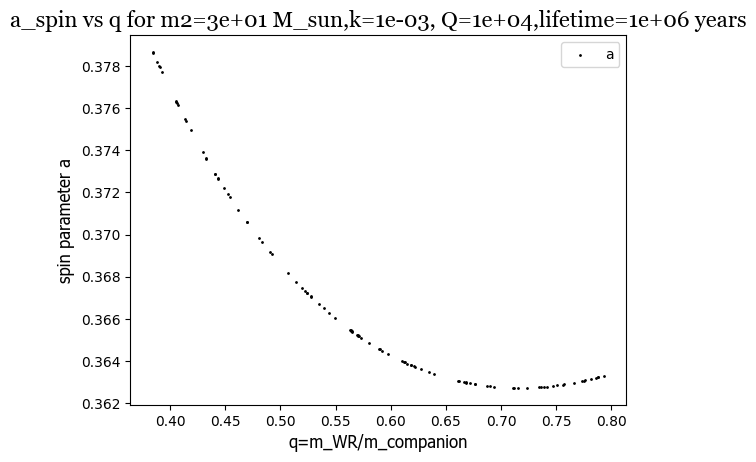

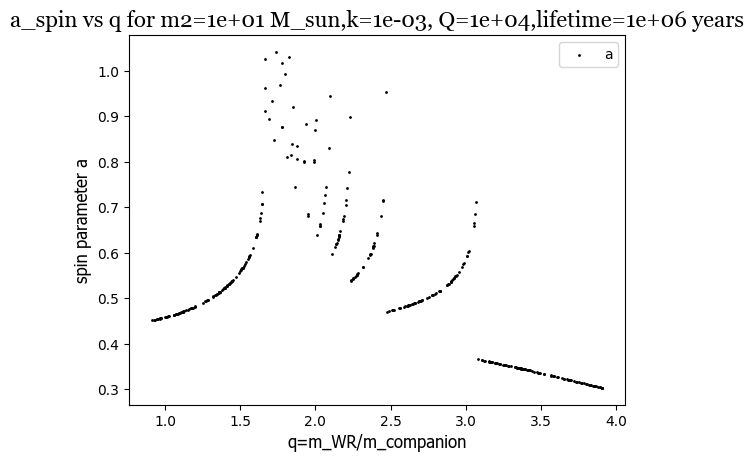

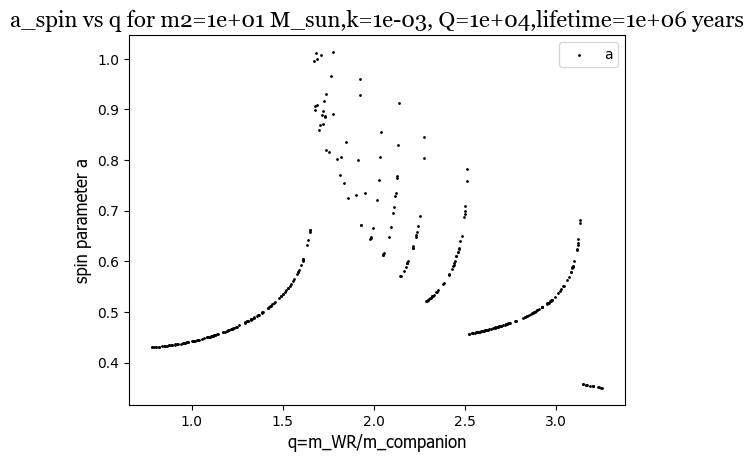

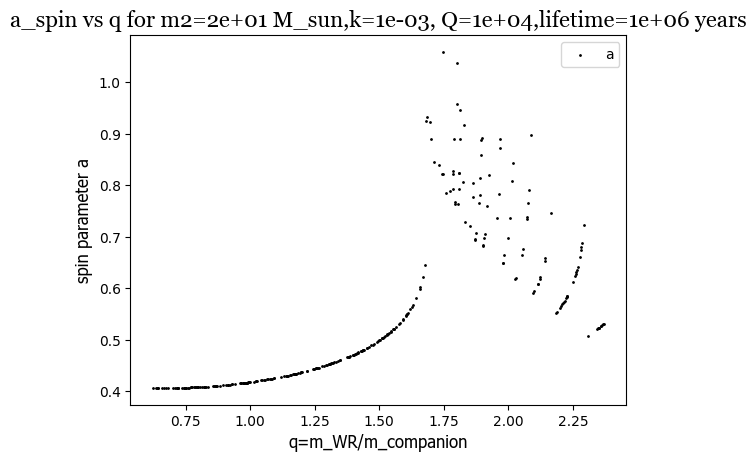

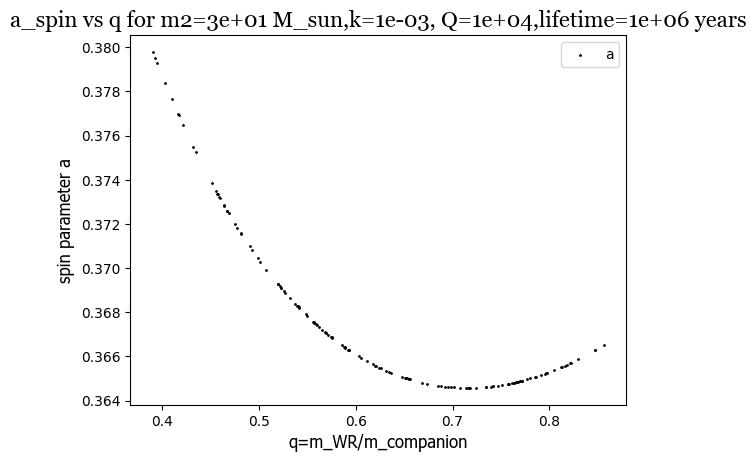

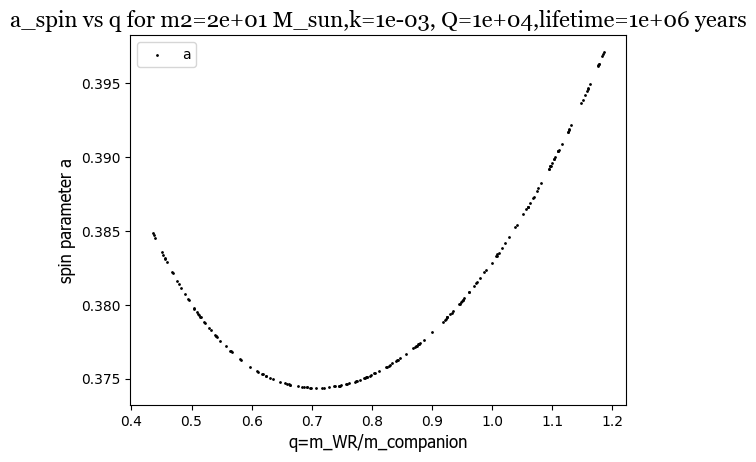

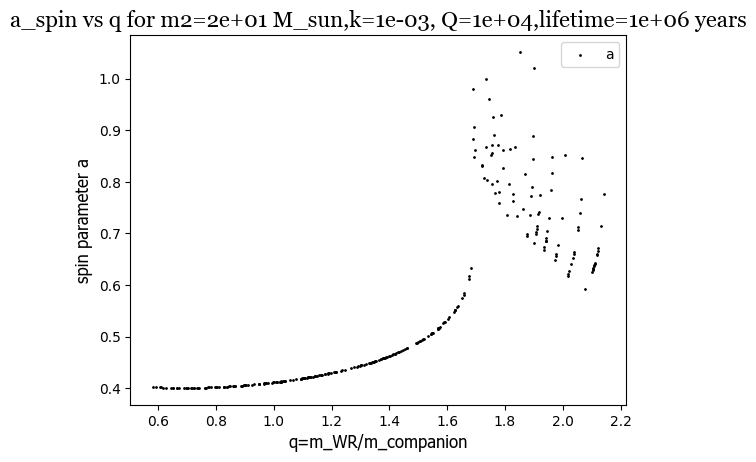

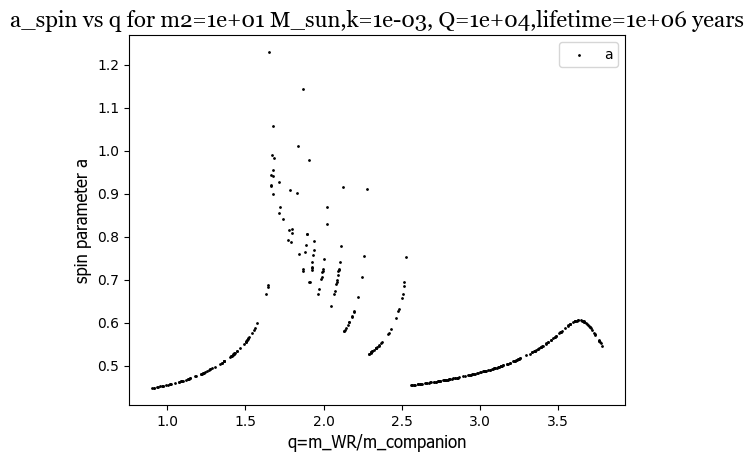

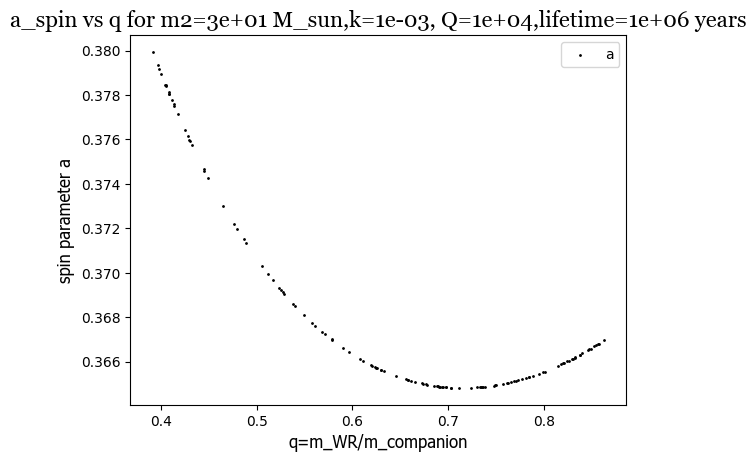

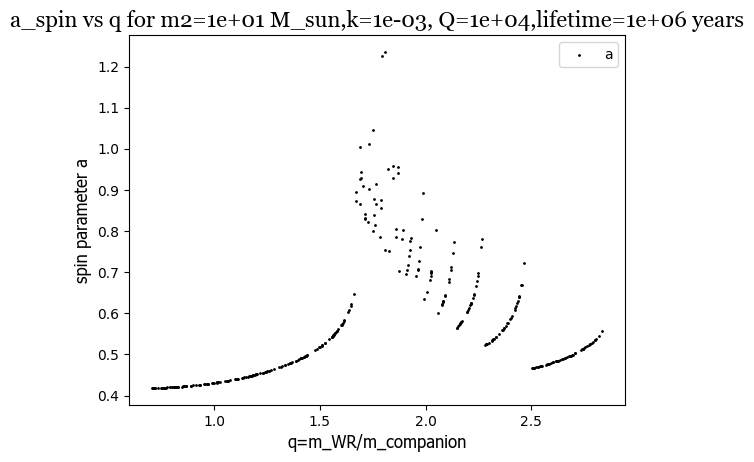

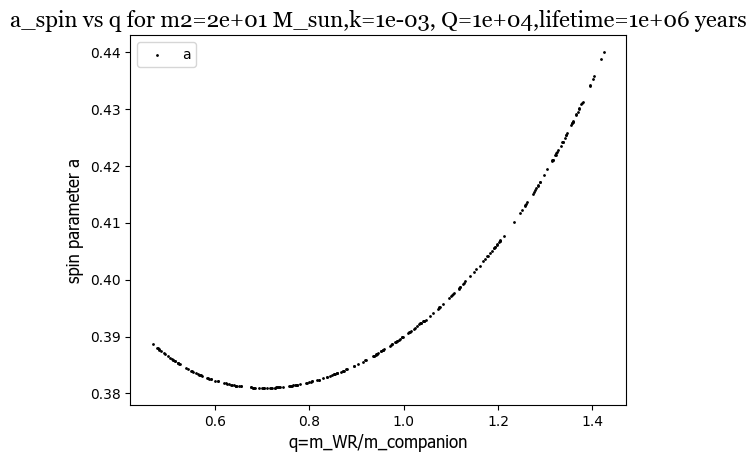

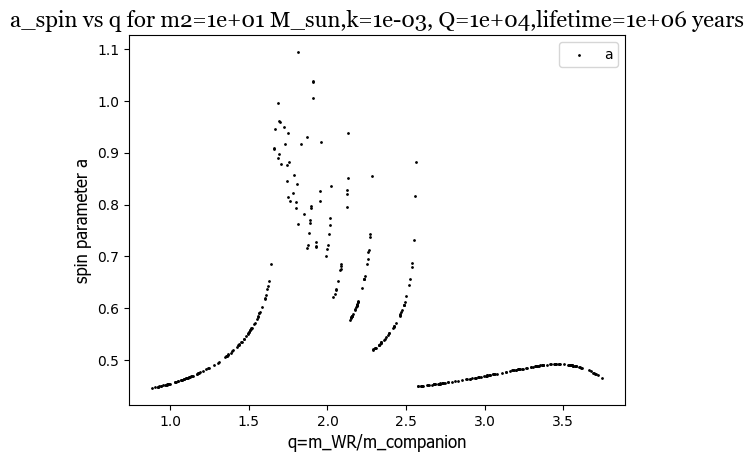

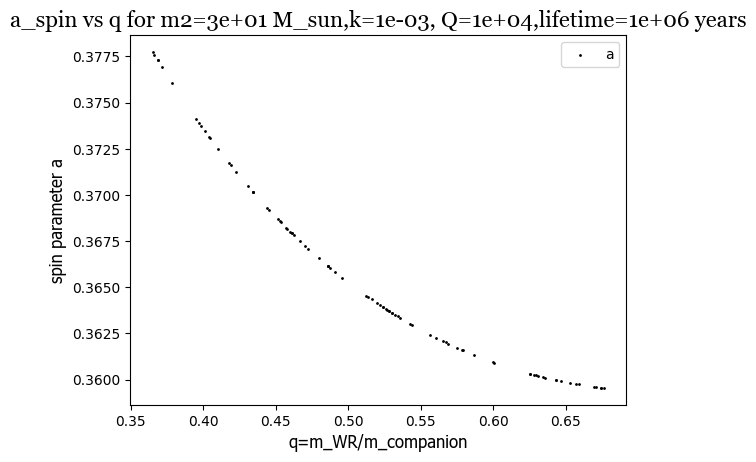

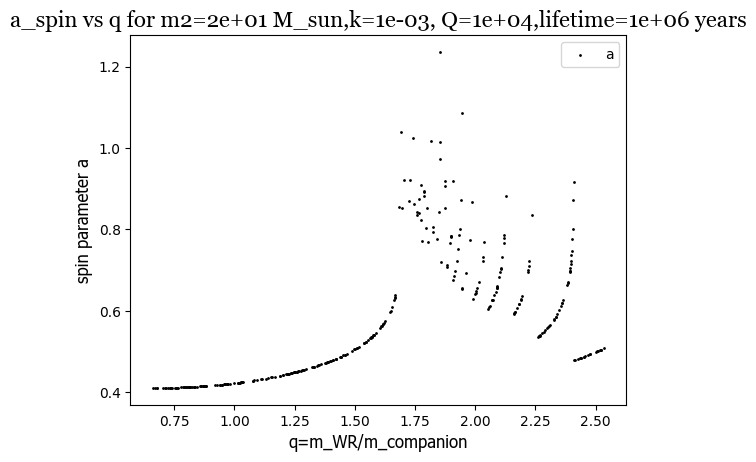

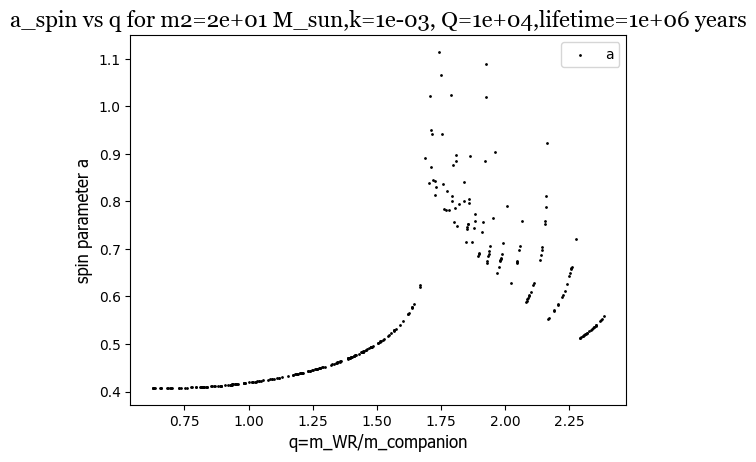

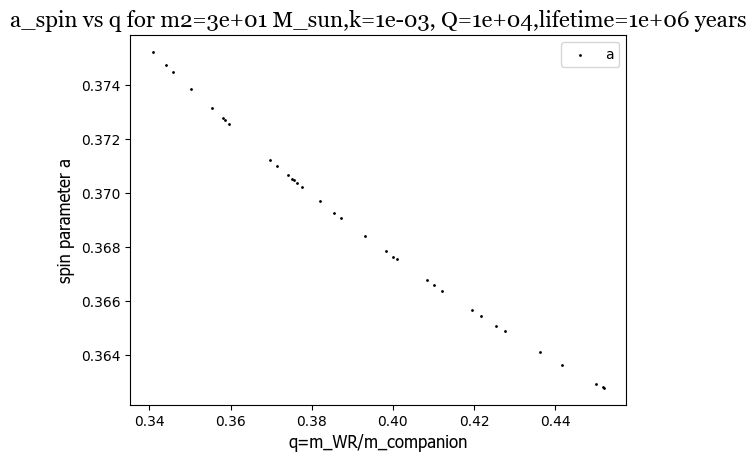

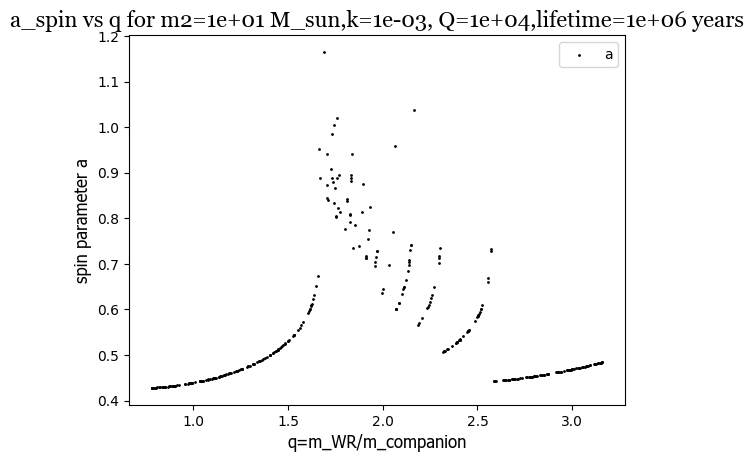

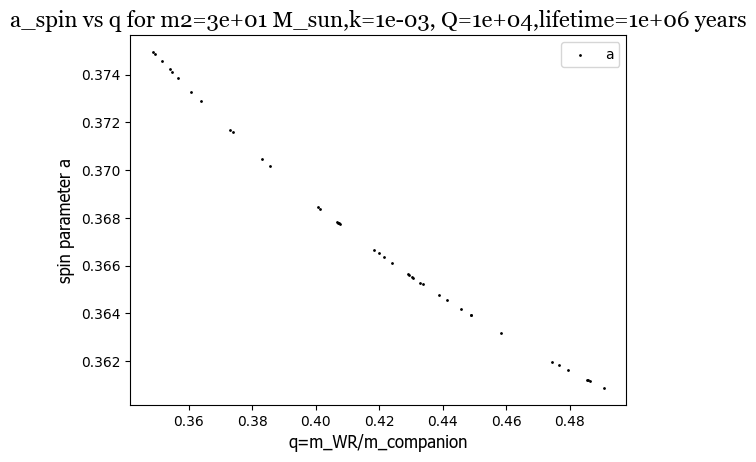

In [18]:
# important libs and constants
import plot_utils as p
import functions as fct
import ODE_solver as odes
import numpy as np
import csv
import random
G = 6.674e-11  # N*m^2/Kg^2
Msolar = 1.989e30  # kg
Rsolar = 6.957e8  # in m
c = 299792458.0  # m/s

# Open the outputfile once, before loops
with open("angular_momentum_output.csv", "w", newline="") as f:
    writer = csv.writer(f)

# Write the header only once
    writer.writerow(["m_WR/M_Sun", "m_companion/M_Sun", "k", 'Q', 'initial separation a0 (m)', 'initial spin Omega0 (Hz)', 'lifetime (years)',
                    'tidal function timescale (years)', 'initial frequency f0 (Hz)', 'f_final (Hz)', 'Omega_final (Hz)', 'final angular momentum J (kg m^2/s")', 'spin parameter a_spin', 'J in terms of a_spin'])

    # shit just got real

    for m2 in [random.uniform(10*Msolar, 100*Msolar) for _ in range(100)]:
        for lifetime in [1000, 10000, 1e5, 1e6]:
            for k in [0.001]:
                for Q in [1e4, 1e5, 1e6, 1e7]:
                    for rg2 in [0.1]:

                        q_values = []
                        a_spin_values = []

                        for m1 in [random.uniform(10*Msolar, 100*Msolar) for _ in range(1000)]:
                            q = m1/m2

                            RWR1 = fct.radius_from_mass(
                                m1/Msolar)  # in solar radii
                            R1 = RWR1*Rsolar  # in m

                            a_max = fct.max_separation(1.36e10, m1, m2)  # in m
                            a_min = fct.min_separation(
                                q, RWR1)  # in solar radii
                            a_min_si = a_min*Rsolar  # in m

                            fmax = fct.gw_frequency(a_max, m1, m2)
                            fmin = fct.gw_frequency(a_min_si, m1, m2)

                            T_TF_max = fct.tidal_friction_timescale(
                                m1, m2, Q, k, a_max, RWR1, fmax)
                            T_TF_min = fct.tidal_friction_timescale(
                                m1, m2, Q, k, a_min_si, RWR1, fmin)

                            tfinal = lifetime*365.25*24*3600  # time in s

                            # checking timescales compared to lifetime, timescale has to be shorter for tides to have time to act
                            for a0 in [2*a_min_si, 3*a_min_si, 4*a_min_si, 5*a_min_si]:
                                f0 = fct.gw_frequency(a0, m1, m2)
                                T_TF = fct.tidal_friction_timescale(
                                    m1, m2, Q, k, a0, RWR1, f0)/(3600*24*365.25)
                                if T_TF <= lifetime:
                                    K1 = (18*k/Q)*(m2*(np.pi**(13/3))*(R1**5)) / \
                                        ((G**(5/3))*m1*rg2*(m1+m2)**(5/3))
                                    K2 = (3*k/Q)*((m2**2)*(np.pi**3)*(R1**3)) / \
                                        (G*m1*rg2*(m1+m2)**2)

                                    def dfdt(f, Omega):
                                        return K1*(f**(13/3))*(f/2-Omega)

                                    def dOmegadt(f, Omega):
                                        return K2*(f**3)*(f/2-Omega)

                                    for Omega0 in [1e-5]:
                                        sols = odes.solve_Radau(
                                            dxdt=dfdt, dydt=dOmegadt, x0=f0, y0=Omega0, t0=0, tfinal=tfinal, x_scale=1, y_scale=1, t_scale=1)

                                        # in years
                                        t = sols[0]/(3600*24*365.25)
                                        f = sols[1]  # in Hz
                                        Omega = sols[2]  # in Hz
                                        J = rg2*m1*(R1**2)*Omega[-1]
                                        a_spin = c*J/(G*m1*m1)

                                        # this one I think is the same as what was on the worksheet aka find J
                                        # how much are the Js in terms of spin parameter a (NOT SEPARATION a) 2in1 yay

                                        writer.writerow(
                                            [m1/Msolar, m2/Msolar, k, Q, a0, Omega0, lifetime, T_TF, f0, f[-1], Omega[-1], J, a_spin, J/a_spin])

                                        q_values.append(q)
                                        a_spin_values.append(a_spin)
                        if q_values != [] and a_spin_values != []:
                            # plot a_spin vs q
                            p.scatter2d(q_values, a_spin_values, xlabel='q=m_WR/m_companion', ylabel='spin parameter a',
                                        title=f'a_spin vs q for m2={format(m2/Msolar, '.0e')} M_sun,k={format(k, '.0e')}, Q={format(Q, '.0e')},lifetime={format(lifetime, '.0e')} years', legend='a(q)', colour='black', xlim=None, size=1, axis_font='Tahoma', axis_size=12, title_font='Georgia', title_size=16, legend_size=10)